In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-p3mpw79d
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-p3mpw79d
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=d2edf728b5d78011d9d4035fa0341261e4daf16530a5f4733482f7729b857de8
  Stored in directory: /tmp/pip-ephem-wheel-cache-p4_ra016/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


In [2]:
import coutils
from coutils import fix_random_seed

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
NUM_TRAIN = 49000

# 참고 사이트: https://green-late7.tistory.com/56
# torchvision.transforms.ToTensor: Convert a PIL Image or numpy.ndarray to "tensor"
# T.Normalize(mean, std)->ex) (0.4914, 0.4822, 0.4465): rgb채널의 평균
# this is for data augmentation
transform = T.Compose([
                       T.ToTensor(),
                       T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# dset = torch.vision.datasets
# 여기서 CIFAR10데이터를, download이면 인터넷에서 다운받아 './datasets'에 저장하고
# Returns:	(image, target) where target is index of the target class.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
#  E.g., in the common case with stochastic gradient decent (SGD)
#  a Sampler could randomly permute a list of indices and yield each one at a time
# or yield a small number of them for mini-batch SGD.
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
# loader_val.dataset.train = True (바로 윗 줄에 train=True가 있음)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


In [4]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda:0


In [5]:
def flatten(x, start_dim=1, end_dim=-1):
    return x.flatten(start_dim=start_dim, end_dim=end_dim)

In [6]:
t = torch.tensor([[[1, 2],
                       [3, 4]],
                      [[5, 6],
                       [7, 8]]])
print(torch.flatten(t, start_dim=0, end_dim=2))
print(torch.flatten(t, start_dim=1, end_dim=2))
print(torch.flatten(t, start_dim=1, end_dim=1))
print(torch.flatten(t))

tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])
tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])
tensor([1, 2, 3, 4, 5, 6, 7, 8])


In [7]:
def two_layer_fc(x, params):
    # first we flatten the image
    # The input to the network will be a minibatch of data, of shape
    # ...(N, d1, ..., dM) where d1 * ... * dM = D
    # 위에서 flatten함수 정의했음 dim=0은 고정하고 나머지를 flatten하도록
    # flatten(x) = x.flatten(start_dim=1)
    x = flatten(x)

    w1, b1, w2, b2 = params

    # import torch.nn.functional as F
    # w1 has shape (H, D) and w2 has shape (C, H)
    # linear: y = x * w1.t() + b1
    x = F.relu(F.linear(x, w1, b1))
    x = F.linear(x, w2, b2)
    return x

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64,3,16,16), dtype=dtype)
    w1 = torch.zeros((hidden_layer_size, 3*16*16), dtype=dtype)
    b1 = torch.zeros((hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((10, hidden_layer_size), dtype=dtype)
    b2 = torch.zeros((10), dtype=dtype)
    scores = two_layer_fc(x, [w1,b1,w2,b2])
    print('output size:', list(scores.size())) # it should [64, 10]

two_layer_fc_test()

output size: [64, 10]


In [8]:
def three_layer_convnet(x, params):
    # shape
    '''
    x = (N, C, H, W)
    conv_w1 = (channel_1, C, KH1, KW1)
    conv_b1 = (channel_1)
    conv_w2 = (channel_2, channel_1, KH2, KW2)
    conv_b2 = (channel_2,)
    fc_w = (class_num, channel_2*h'*w') 
    fc_b = (class_num)
    웬만하면 (h',w')==(H,W)
    '''
    # conv(padding:2) - relu - conv(padding:1) - relu - fullY_connected
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    # stride=1이 기본, padding=0이 기본
    y1 = F.relu(F.conv2d(x, conv_w1,conv_b1, padding=2)) # (N, channel_1, h, w)
    y2 = F.relu(F.conv2d(y1, conv_w2, conv_b2, padding=1)) # (N, channel_2, h', w')
    y2 = flatten(y2) # (N, channel_2*h'*w')
    scores = F.linear(y2, fc_w, fc_b)
    
    return scores

In [9]:
def three_layer_convnet_test():
  x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

  conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
  conv_b1 = torch.zeros((6,))  # out_channel
  conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
  conv_b2 = torch.zeros((9,))  # out_channel

  # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
  fc_w = torch.zeros((10, 9 * 32 * 32))
  fc_b = torch.zeros(10)

  scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
  print('Output size:', list(scores.size()))  # you should see [64, 10]
three_layer_convnet_test()

Output size: [64, 10]


In [10]:
fix_random_seed(0)
# create a weight of shape [3 x 5]
# import torch.nn as nn
print(nn.init.kaiming_normal_(torch.empty(3,5, dtype=dtype, device=device)))
print(nn.init.zeros_(torch.empty(3,5, dtype=dtype, device=device)))

tensor([[-0.5848, -0.2690, -1.6721,  0.0918, -0.0764],
        [-0.3667, -0.3939, -0.2077, -0.6796, -0.2297],
        [-1.0569,  1.4328,  0.1971, -0.1165,  0.8137]], device='cuda:0')
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')


In [11]:
# accuracy를 계산할때는 pytorch가 backpropagaion을 위한 graph를 만들지 않아도 됨
def check_accuracy_part2(loader, model_fn, params):
    split = 'val' if loader.dataset.train else 'test'
    print(f'checking accuracy on the {split} set')
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            scores = model_fn(x, params)
            M, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples *100
        print(f'Got {num_correct} / {num_samples} ({acc:.2f})')


In [12]:
a = torch.tensor([1, 2])
print(a.size())
print(a.size(0))
b = torch.tensor([[1,2,3],[1,3,4]])
print(b.size())
print(b.size(0))
print(b.size(1))

torch.Size([2])
2
torch.Size([2, 3])
2
3


In [13]:
def train_part2(model_fn, params, learning_rate):
    for t, (x,y) in enumerate(loader_train):
        # move the data to the proper device GPU or CPU
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=ltype)

        # forward
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # backward
        loss.backward()

        with torch.no_grad():
            for w in params:
                if w.requires_grad:
                    w -= learning_rate * w.grad
                    # Manually zero the gradients after running the backward pass
                    w.grad.zero_()
        
        if t % print_every == 0 or t == len(loader_train)-1:
            print(f'Iteration {t}, loss = {loss.item():.4f}')
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the second dimension of `w1`. 
The first dimension of `w1` is the hidden layer size, which will also be the second dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

You don't need to tune any hyperparameters but you should see accuracies above 40% after training for one epoch.

In [14]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = nn.init.kaiming_normal_(torch.empty(hidden_layer_size, C*H*W, dtype=dtype, device=device))
w1.requires_grad = True
w2 = nn.init.kaiming_normal_(torch.empty(num_classes, hidden_layer_size, dtype=dtype, device=device))
w2.requires_grad = True

# torch.nn.init.zeros_(tensor)
b1 = nn.init.zeros_(torch.empty(hidden_layer_size, dtype=dtype, device=device))
b1.requires_grad = True
b2 = nn.init.zeros_(torch.empty(num_classes, dtype=dtype, device=device))
b2.requires_grad = True

train_part2(two_layer_fc, [w1, b1, w2, b2], learning_rate)

Iteration 0, loss = 3.5134
checking accuracy on the val set
Got 153 / 1000 (15.30)

Iteration 100, loss = 2.8268
checking accuracy on the val set
Got 363 / 1000 (36.30)

Iteration 200, loss = 2.1683
checking accuracy on the val set
Got 396 / 1000 (39.60)

Iteration 300, loss = 1.8409
checking accuracy on the val set
Got 419 / 1000 (41.90)

Iteration 400, loss = 1.5695
checking accuracy on the val set
Got 430 / 1000 (43.00)

Iteration 500, loss = 2.1471
checking accuracy on the val set
Got 414 / 1000 (41.40)

Iteration 600, loss = 1.9083
checking accuracy on the val set
Got 404 / 1000 (40.40)

Iteration 700, loss = 1.8546
checking accuracy on the val set
Got 422 / 1000 (42.20)

Iteration 765, loss = 1.5771
checking accuracy on the val set
Got 397 / 1000 (39.70)



### BareBones PyTorch: Training a ConvNet

In the below you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy above 45% after one epoch.

In [15]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

channel_1 = 32
channel_2 = 16
kernel_size_1 = 5
kernel_size_2 = 3

learning_rate = 3e-3
conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None


################################################################################
# TODO: Define and initialize the parameters of a three-layer ConvNet          #
#       using nn.init.kaiming_normal_.                                         #
################################################################################
# Replace "pass" statement with your code
conv_w1 = nn.init.kaiming_normal_(torch.empty(channel_1, C, kernel_size_1, kernel_size_1, dtype=dtype, device=device))
conv_w1.requires_grad = True
conv_w2 = nn.init.kaiming_normal_(torch.empty(channel_2, channel_1, kernel_size_2, kernel_size_2, dtype=dtype, device=device))
conv_w2.requires_grad = True

# torch.nn.init.zeros_(tensor)
conv_b1 = nn.init.zeros_(torch.empty(channel_1, dtype=dtype, device=device))
conv_b1.requires_grad = True
conv_b2 = nn.init.zeros_(torch.empty(channel_2, dtype=dtype, device=device))
conv_b2.requires_grad = True

fc_w = nn.init.kaiming_normal_(torch.empty(num_classes, channel_2*H*W, dtype=dtype, device=device))
fc_w.requires_grad = True
fc_b = nn.init.zeros_(torch.empty(num_classes, dtype=dtype, device=device))
fc_b.requires_grad = True
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 2.6007
checking accuracy on the val set
Got 109 / 1000 (10.90)

Iteration 100, loss = 1.9966
checking accuracy on the val set
Got 351 / 1000 (35.10)

Iteration 200, loss = 1.7885
checking accuracy on the val set
Got 392 / 1000 (39.20)

Iteration 300, loss = 1.6612
checking accuracy on the val set
Got 416 / 1000 (41.60)

Iteration 400, loss = 1.5945
checking accuracy on the val set
Got 450 / 1000 (45.00)

Iteration 500, loss = 1.6625
checking accuracy on the val set
Got 448 / 1000 (44.80)

Iteration 600, loss = 1.6294
checking accuracy on the val set
Got 470 / 1000 (47.00)

Iteration 700, loss = 1.7863
checking accuracy on the val set
Got 483 / 1000 (48.30)

Iteration 765, loss = 1.2418
checking accuracy on the val set
Got 461 / 1000 (46.10)



# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network.
We use `nn.init.kaiming_normal_` to initialize weights using Kaiming initialization, and `nn.init.kaiming_zeros_` to initialize biases.

In [16]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 3*16*16
    x = torch.zeros((64, input_size), dtype=dtype)
    model =TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print('architecture: ')
    print(model)
    print('output size', list(scores.size()))
test_TwoLayerFC()

architecture: 
TwoLayerFC(
  (fc1): Linear(in_features=768, out_features=42, bias=True)
  (fc2): Linear(in_features=42, out_features=10, bias=True)
)
output size [64, 10]


### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

We assume that the size of the input of this network is `H = W = 32`, and there is no pooing; this information is required when computing the number of input channels in the last fully-connected layer.
You should initialize the weight matrices of the model using Kaiming normal initialization, and zero out the bias vectors.

**HINT**: [torch.nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d), [torch.nn.init.kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_), [torch.nn.init.zeros_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.zeros_)

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [17]:
class ThreeLayerConvNet(nn.Module):
  def __init__(self, in_channel, channel_1, channel_2, num_classes):
    super().__init__()
    ########################################################################
    # TODO: Set up the layers you need for a three-layer ConvNet with the  #
    # architecture defined above.                                          #
    ########################################################################
    # Replace "pass" statement with your code
    self.conv1 = nn.Conv2d(in_channel, channel_1, 5, padding=2)
    self.conv2 = nn.Conv2d(channel_1, channel_2, 3, padding=1)
    self.fc = nn.Linear(channel_2*32*32, num_classes)

    nn.init.kaiming_normal_(self.conv1.weight)
    nn.init.kaiming_normal_(self.conv2.weight)
    nn.init.kaiming_normal_(self.fc.weight)
    ########################################################################
    #                           END OF YOUR CODE                           #     
    ########################################################################

  def forward(self, x):
    scores = None
    ########################################################################
    # TODO: Implement the forward function for a 3-layer ConvNet. you      #
    # should use the layers you defined in __init__ and specify the        #
    # connectivity of those layers in forward()                            #
    ########################################################################
    # Replace "pass" statement with your code
    x = F.relu(self.conv2(F.relu(self.conv1(x))))
    x = flatten(x)
    scores = self.fc(x)
    ########################################################################
    #                            END OF YOUR CODE                          #
    ########################################################################
    return scores


def test_ThreeLayerConvNet():
  x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
  model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
  scores = model(x)
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_ThreeLayerConvNet()

ThreeLayerConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)
Output size: [64, 10]


In [18]:
def check_accuracy_part34(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [19]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
      for param_group in optimizer.param_groups:
          print(f'lr decay form {param_group["lr"]} to {param_group["lr"] * lrd}')
          param_group['lr'] *= lrd

def train_part345(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
      num_prints = num_iters // print_every + 1 # 마지막 훈련 다했을 때 출력하기 위해 1 더해줌
  else:
      num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=dtype)
  iter_history = torch.zeros(num_prints, dtype=ltype)
  for e in range(epochs):
    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

    for t, (x, y) in enumerate(loader_train):
        model.train()  # put model to training mode
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=ltype)
        
        scores = model(x)
        loss = F.cross_entropy(scores, y)

        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()
      
        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
          
        # 시행 횟수
        tt = t + e * len(loader_train)
        # 출력 해야되거나 또는 마지막의 값은 출력
        if verbose and (tt % print_every == 0 or (e == epochs -1 and t == len(loader_train)-1)):
          print(f'Epoch {e}, Iteration {tt}, loss = {loss.item():.4f}')
          acc = check_accuracy_part34(loader_val, model)
          acc_history[tt // print_every] = acc
          iter_history[tt // print_every] = tt
          print()
        elif not verbose and (t == len(loader_train)-1):
          print(f'Epoch {e}, Iteration {tt}, loss = {loss.item():.4f}')
          acc = check_accuracy_part34(loader_val, model)
          acc_history[e] = acc
          iter_history[e] = tt
          print()
  return acc_history, iter_history

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch.

In [20]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
# 람다*|w|^2 regulazation 
weight_decay = 1e-4

model = TwoLayerFC(C*H*W, hidden_layer_size, num_classes)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

_ = train_part345(model, optimizer)

Epoch 0, Iteration 0, loss = 3.3988
Checking accuracy on validation set
Got 139 / 1000 correct (13.90)

Epoch 0, Iteration 100, loss = 2.9726
Checking accuracy on validation set
Got 328 / 1000 correct (32.80)

Epoch 0, Iteration 200, loss = 2.1085
Checking accuracy on validation set
Got 336 / 1000 correct (33.60)

Epoch 0, Iteration 300, loss = 2.1709
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)

Epoch 0, Iteration 400, loss = 1.9805
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)

Epoch 0, Iteration 500, loss = 1.7867
Checking accuracy on validation set
Got 447 / 1000 correct (44.70)

Epoch 0, Iteration 600, loss = 2.1035
Checking accuracy on validation set
Got 473 / 1000 correct (47.30)

Epoch 0, Iteration 700, loss = 1.6729
Checking accuracy on validation set
Got 472 / 1000 correct (47.20)

Epoch 0, Iteration 765, loss = 1.6794
Checking accuracy on validation set
Got 413 / 1000 correct (41.30)



### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above above 45% after training for one epoch.

You should train the model using stochastic gradient descent without momentum, with L2 weight decay of 1e-4.

In [21]:
fix_random_seed(0)

C = 3
num_classes = 10

channel_1 = 32
channel_2 = 16

learning_rate = 3e-3
weight_decay = 1e-4

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer.#
################################################################################
# Replace "pass" statement with your code
model = ThreeLayerConvNet(C, channel_1, channel_2, num_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

_ = train_part345(model, optimizer)

Epoch 0, Iteration 0, loss = 3.5163
Checking accuracy on validation set
Got 126 / 1000 correct (12.60)

Epoch 0, Iteration 100, loss = 1.9024
Checking accuracy on validation set
Got 352 / 1000 correct (35.20)

Epoch 0, Iteration 200, loss = 1.7836
Checking accuracy on validation set
Got 418 / 1000 correct (41.80)

Epoch 0, Iteration 300, loss = 1.7462
Checking accuracy on validation set
Got 461 / 1000 correct (46.10)

Epoch 0, Iteration 400, loss = 1.4010
Checking accuracy on validation set
Got 451 / 1000 correct (45.10)

Epoch 0, Iteration 500, loss = 1.6621
Checking accuracy on validation set
Got 477 / 1000 correct (47.70)

Epoch 0, Iteration 600, loss = 1.3361
Checking accuracy on validation set
Got 483 / 1000 correct (48.30)

Epoch 0, Iteration 700, loss = 1.6075
Checking accuracy on validation set
Got 501 / 1000 correct (50.10)

Epoch 0, Iteration 765, loss = 1.5330
Checking accuracy on validation set
Got 493 / 1000 correct (49.30)



# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

Before we start, We need to wrap `flatten` function in a module in order to stack it in `nn.Sequential`.
As of 1.3.0, PyTorch supports `nn.Flatten`, so this is not required in the latest version.
However, let's use the following `Flatten` class for backward compatibility for now.

In [22]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.
Here, let's skip weight initialization for simplicity;
with a more advanced optimizer than the naive SGD, the default initialization provided in `torch.nn` is good enough for shallow networks.

Again, you don't need to tune any hyperparameters here, but you should achieve above 40% accuracy after one epoch of training.

In [23]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
momentum = 0.5

model = nn.Sequential(OrderedDict([
    ('flatten', Flatten()),
    ('fc1', nn.Linear(C*H*W, hidden_layer_size)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(hidden_layer_size, num_classes)),
]))

print('architecture')
print(model)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay,
                    momentum=momentum, nesterov=True)

_ = train_part345(model, optimizer)

architecture
Sequential(
  (flatten): Flatten()
  (fc1): Linear(in_features=3072, out_features=4000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4000, out_features=10, bias=True)
)
Epoch 0, Iteration 0, loss = 2.3772
Checking accuracy on validation set
Got 137 / 1000 correct (13.70)

Epoch 0, Iteration 100, loss = 1.7474
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Epoch 0, Iteration 200, loss = 1.7006
Checking accuracy on validation set
Got 409 / 1000 correct (40.90)

Epoch 0, Iteration 300, loss = 1.6135
Checking accuracy on validation set
Got 444 / 1000 correct (44.40)

Epoch 0, Iteration 400, loss = 1.6331
Checking accuracy on validation set
Got 457 / 1000 correct (45.70)

Epoch 0, Iteration 500, loss = 1.5453
Checking accuracy on validation set
Got 460 / 1000 correct (46.00)

Epoch 0, Iteration 600, loss = 1.4802
Checking accuracy on validation set
Got 470 / 1000 correct (47.00)

Epoch 0, Iteration 700, loss = 1.6623
Checking accuracy on validati

### Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You don't have to re-initialize your weight matrices and bias vectors.

You should optimize your model using stochastic gradient descent with Nesterov momentum 0.5, with L2 weight decay of 1e-4..

Again, you don't need to tune any hyperparameters but you should see accuracy above 50% after one epoch of training.

In [24]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

channel_1 = 32
channel_2 = 16
kernel_size_1 = 5
pad_size_1 = 2
kernel_size_2 = 3
pad_size_2 = 1

learning_rate = 1e-2
momentum = 0.5

model = None
optimizer = None
################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# Replace "pass" statement with your code
model = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(C, channel_1, kernel_size_1, padding=pad_size_1)),
    ('relu', nn.ReLU()),
    ('conv2', nn.Conv2d(channel_1, channel_2, kernel_size_2, padding=pad_size_2)),
    ('relu', nn.ReLU()),
    ('flatten', Flatten()),
    ('fc', nn.Linear(channel_2*H*W, num_classes)),
]))

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay,
                    momentum=momentum, nesterov=True)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.

_ = train_part345(model, optimizer)

Architecture:
Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten()
  (fc): Linear(in_features=16384, out_features=10, bias=True)
)
Epoch 0, Iteration 0, loss = 2.3094
Checking accuracy on validation set
Got 173 / 1000 correct (17.30)

Epoch 0, Iteration 100, loss = 1.6233
Checking accuracy on validation set
Got 403 / 1000 correct (40.30)

Epoch 0, Iteration 200, loss = 1.3689
Checking accuracy on validation set
Got 456 / 1000 correct (45.60)

Epoch 0, Iteration 300, loss = 1.8044
Checking accuracy on validation set
Got 483 / 1000 correct (48.30)

Epoch 0, Iteration 400, loss = 1.5621
Checking accuracy on validation set
Got 513 / 1000 correct (51.30)

Epoch 0, Iteration 500, loss = 1.4392
Checking accuracy on validation set
Got 515 / 1000 correct (51.50)

Epoch 0, Iteration 600, loss = 1.4302
Checking accuracy on validation set
Got 535 /

# Part V. ResNet for CIFAR-10

In this section, you are going to implement [ResNet](https://arxiv.org/abs/1512.03385), one of the state-of-the-art CNN architecture.
Specifically, you are going to implement a variation of ResNet called [PreResNet](https://arxiv.org/abs/1603.05027), which locates activation before each convolutional layer (so called pre-activation).
You are going to first implement a plain building block, residual block, and then bottleneck block for really deep networks.
Finally, you will implement your own ResNet using those blocks.

Throughout this part, we will follow the PyTorch default weight initialization for conciseness.

## Plain block

First, let's implement a plain block without residual connection.
PreResNet has a different order of layers from the previously implemented ones;
BatchNorm and ReLU precedes Conv.
The name of PreResNet comes form this pre-activation architecture.
Here, for downsampling, we don't introduce MaxPool layers explicitly, but use stride 2 in the first Conv layer in the block.

Concretely, a plain block accepts a feature map of shape $C_{in} \times H_{in} \times W_{out}$ and produces a feature map of shape $C_{out} \times H_{out} \times W_{out}$. If the block performs downsampling, then $W_{out}=W_{in}/2$ and $H_{out}=H_{in}/2$; otherwise $H_{out}=H_{in}$ and $W_{out}=W_{in}$. The plain block consists of the following six layers in order:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout` 3x3 filters, zero-padding of 1, and stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout` 3x3 filters, with zero-padding of 1


In [31]:
class PlainBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.net = None
    ############################################################################
    # TODO: Implement plain block.                                             #
    # Hint: Wrap your layers by nn.Sequential() to output a single module.     #
    #       You don't have use OrderedDict.                                    #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the result in self.net.                                            #
    ############################################################################
    # Replace "pass" statement with your code
    st = 2 if downsample else 1
    self.net = nn.Sequential(
        nn.BatchNorm2d(Cin),
        nn.ReLU(),
        nn.Conv2d(Cin, Cout, 3, stride=st, padding=1),
        nn.BatchNorm2d(Cout),
        nn.ReLU(),
        nn.Conv2d(Cout, Cout,3, padding=1)
    )
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################

  def forward(self, x):
    return self.net(x)

In [32]:
data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of PlainBlock without downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))
data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of PlainBlock with downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of PlainBlock without downsampling has a *correct* dimension!
The output of PlainBlock with downsampling has a *correct* dimension!


## Residual block

Next, let's implement a residual block.
A residual block adds a residual connection to a plain block. Let $\mathcal{F}$ be a plain block; then the residual version  $\mathcal{R}$ of the plain block $\mathcal{F}$ computes:

$\mathcal{R}(x) = \mathcal{F}(x) + x$

However, this implementation will only work if the output from the plain block $\mathcal{F}(x)$ has the same shape as the input $x$. Based on the plain block that we implemented above, there are two cases where the output of the plain block can have a different shape than the input:

1. The number of output channels $C_{out}$ is different from the number of input channels $C_{in}$
2. The plain block $\mathcal{F}$ performs spatial downsampling

To deal with these cases, we need generalize our definition of the residual block and add a *shortcut connection* $\mathcal{G}$:

$\mathcal{R}(x) = \mathcal{F}(x) + \mathcal{G}(x)$

There are three cases for the shortcut connection $\mathcal{G}$:

1. If $C_{in}=C_{out}$ and $\mathcal{F}$ does not perform downsampling, then $\mathcal{F}(x)$ will have the same shape as $x$, so $\mathcal{G}$ is the identity function: $\mathcal{G}(x) = x$
2. If $C_{in} \neq C_{out}$ and $\mathcal{F}$ does not downsample, then $\mathcal{G}$ is a 1x1 convolution with $C_out$ filters and stride 1.
3. If $\mathcal{F}$ downsamples, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 2.

In the code below, implement a residual block using the plain block we just defined:

In [36]:
class ResidualBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.block = None # F
    self.shortcut = None # G
    ############################################################################
    # TODO: Implement residual block using plain block. Hint: nn.Identity()    #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the main block in self.block and the shortcut in self.shortcut.    #
    ############################################################################
    # Replace "pass" statement with your code
    self.block = PlainBlock(Cin, Cout, downsample)
    if Cin == Cout and not downsample:
        self.shortcut = nn.Sequential(nn.Identity())
    elif Cin != Cout and not downsample:
        self.shortcut = nn.Sequential(nn.Conv2d(Cin, Cout, 1))
    else:
        self.shortcut = nn.Sequential(nn.Conv2d(Cin, Cout, 1, stride=2))
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################
  
  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [37]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


## Residual stage

So far, you implemented micro layers, which consists of several convolutional laters.
To efficiently build a deep neural network, we define a macro layer by repeating the micro layers.

For your convenience, we provide the implementation below.

In [41]:
class ResNetStage(nn.Module):
    def __init__(self, Cin, Cout, num_blocks, downsample=True, block=ResidualBlock):
        super().__init__()
        blocks = [block(Cin, Cout, downsample)]
        for _ in range(num_blocks  - 1):
            blocks.append(block(Cout, Cout))
        self.net = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.net(x)

In [42]:
print('Plain block stage:')
print(ResNetStage(3, 4, 2, block=PlainBlock))
print('Residual block stage:')
print(ResNetStage(3, 4, 2, block=ResidualBlock))

Plain block stage:
ResNetStage(
  (net): Sequential(
    (0): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)
Residual block stage:
ResNetStage(
  (net): Sequential(
    (0): 

## Residual stem

A "stem" layer is required at the beginning of the network, which increases the number of channels while keeping the other dimensions.

For your convenience, we provide the implementation below.

In [45]:
class ResNetStem(nn.Module):
    def __init__(self, Cin=3, Cout=8):
        super().__init__()
        layers = [
            nn.Conv2d(Cin, Cout, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
        ]
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [46]:
data = torch.zeros(2, 3, 5, 6)
model = ResNetStem(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!


## ResNet class

Now, it is time to design the ResNet class using the blocks you implemented above!

For general applicability, the class will get a dictionary of the architecture specification as an input, and parse it to build a CNN.

Here we provide a couple of examples of specification;
`networks` is a collection of pre-defined network specifications, where each can be called by `get_resnet(key)`, where key is the name of the network, e.g., `get_resnet('resnet32')` will return a ResNet with 32 layers.

Each specification consists of multiple tuples which correspond to a macro block (`ResNetStage`), and the values in each tuple implies `(num_in_channels, num_out_channels, num_blocks, do_downsample)`.

To avoid dependency on the size of the input, ResNet has an average pooling at the end of the convolutional part, such that the size of the input tensor to the linear layer is always `(batch_size, stage_args[-1][1])`.
You may want to add an average pooling layer (`nn.AvgPool2d`), but it requires to know the size of the input.
Can you relax this requirement?

**Hint**: You can perform average pooling in `forward`.

In [47]:
# example of specifications
networks = {
    'plain32' : {
        'block': PlainBlock,
        'stage_args': [
            (8, 8, 5, False),
            (8, 16, 5, False),
            (16, 32, 5, False),          
    ]
    },
    'resnet32': {
        'block': ResidualBlock,
        'stage_args': [
            (8, 8, 5, False),
            (8, 16, 5, True),
            (16, 32, 5, True),
        ]
    }
}

In [ ]:
# nn.AvgPool2d 작동에 대한 첨언
import torch
import torch.nn as nn
# pool of square window of size=3, stride=3
m = nn.AvgPool2d(3)
output = m(input)
print(output.shape)
# pool of non-square window
m = nn.AvgPool2d((3, 2), stride=(2, 1))
input = torch.randn(20, 16, 50, 32)
output = m(input)

In [90]:
class ResNet(nn.Module):
  def __init__(self, stage_args, Cin=3, block=ResidualBlock, num_classes=10):
    super().__init__()

    self.cnn = None
    ############################################################################
    # TODO: Implement the convolutional part of ResNet using ResNetStem,       #
    #       ResNetStage, and wrap the modules by nn.Sequential.                #
    # Store the model in self.cnn.                                             #
    ############################################################################
    # Replace "pass" statement with your code
    blocks = [ResNetStem(Cin, stage_args[0][0])]
    for arg in stage_args:
        blocks.append(ResNetStage(*arg, block=block))
    self.cnn = nn.Sequential(*blocks)
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################
    self.fc = nn.Linear(stage_args[-1][1], num_classes)
  
  def forward(self, x):
    scores = None
    ############################################################################
    # TODO: Implement the forward function of ResNet.                          #
    # Store the output in `scores`.                                            #
    ############################################################################
    # Replace "pass" statement with your code
    out = self.cnn(x)
    # print('out', out.shape) [64, 32, 32, 32] 64: batchsize, 32: (channel, H, W)
    pool = nn.AvgPool2d((out.shape[2], out.shape[3])) # H, W에 대해 평균 avgpool
    out = pool(out) # [64, 32, 1, 1]
    out = flatten(out) # 따라서 위에서 32*1*1 를 32로 flatten시켜줘야 함
    scores = self.fc(out)
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################
    return scores

def get_resnet(name):
  return ResNet(**networks[name])

## Train your model!

Now let's train a few epochs of plain and residual networks with 32 layers on CIFAR.
You will see that deep non-residual networks don't converge well.

**Caution: This takes a long time!**

**Disclaimer: The performance of PreResNet-32 you will see here (~ 80%) would be lower than the best performance this model can achieve, because the convergence requires much more training.**

In [70]:
names = ['plain32', 'resnet32']
acc_history_dict = {}
iter_history_dict = {}
iter_history_dict = {}
for name in names:
    fix_random_seed(0)
    print('<', name, '>')
    model = get_resnet(name)

    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-4)

    acc_history_dict[name], iter_history_dict[name] = train_part345(model, optimizer, epochs=10, schedule=[6,8], verbose=False)

< plain32 >
Epoch 0, Iteration 765, loss = 1.4295
Checking accuracy on validation set
Got 376 / 1000 correct (37.60)

Epoch 1, Iteration 1531, loss = 1.0581
Checking accuracy on validation set
Got 419 / 1000 correct (41.90)

Epoch 2, Iteration 2297, loss = 1.3484
Checking accuracy on validation set
Got 447 / 1000 correct (44.70)

Epoch 3, Iteration 3063, loss = 1.2570
Checking accuracy on validation set
Got 471 / 1000 correct (47.10)

Epoch 4, Iteration 3829, loss = 1.5386
Checking accuracy on validation set
Got 567 / 1000 correct (56.70)

Epoch 5, Iteration 4595, loss = 1.2356
Checking accuracy on validation set
Got 552 / 1000 correct (55.20)

lr decay form 0.01 to 0.001
Epoch 6, Iteration 5361, loss = 1.0416
Checking accuracy on validation set
Got 646 / 1000 correct (64.60)

Epoch 7, Iteration 6127, loss = 0.8595
Checking accuracy on validation set
Got 659 / 1000 correct (65.90)

lr decay form 0.001 to 0.0001
Epoch 8, Iteration 6893, loss = 0.9369
Checking accuracy on validation set


KeyError: ignored

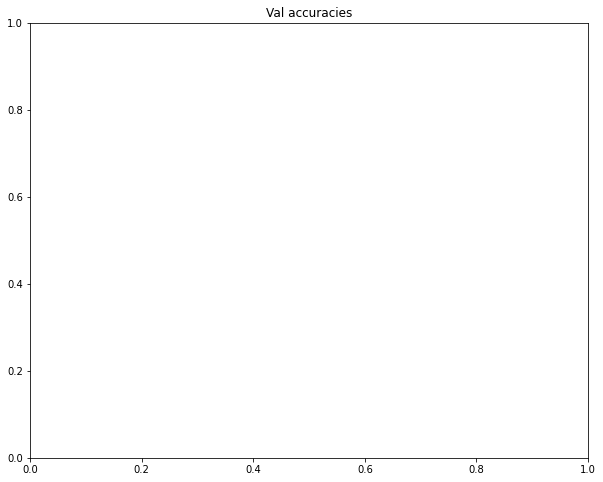

In [81]:
plt.title('Val accuracies')
for name in names:
    plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='upper left')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Residual bottleneck block

A bottleneck block is often useful for better efficiency, especially when importing a model to mobile devices.
The residual bottleneck block is similar to the standard residual block, but the plain block part has a different architecture:
it consists of 3 convolutional layers, and the first two convolutional layers have a smaller number of channels.

Here is the specification of the bottleneck block:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout // 4` 1x1 filters, stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout // 4` 3x3 filters, with zero-padding of 1
7. Spatial Batch normalization
8. ReLU
9. Convolutional layer with `Cout` 1x1 filters

Don't forget to add the residual connection!

In [86]:
class ResidualBottleneckBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.block = None
    self.shortcut = None
    ############################################################################
    # TODO: Implement residual bottleneck block.                               #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the main block in self.block and the shortcut in self.shortcut.    #
    ############################################################################
    # Replace "pass" statement with your code
    st = 2 if downsample else 1
    self.block = nn.Sequential(
        nn.BatchNorm2d(Cin),
        nn.ReLU(),
        # padding = 0 이 기본
        nn.Conv2d(Cin, Cout//4, 1, stride=st),
        nn.BatchNorm2d(Cout//4),
        nn.ReLU(),
        nn.Conv2d(Cout//4, Cout//4, 3, padding=1),
        nn.BatchNorm2d(Cout//4),
        nn.ReLU(),
        nn.Conv2d(Cout//4, Cout, 1),
    )
    if Cin == Cout and not downsample:
        self.shortcut = nn.Sequential(nn.Identity())
    elif Cin != Cout and not downsample:
        self.shortcut = nn.Sequential(nn.Conv2d(Cin, Cout, 1))
    else:
        self.shortcut = nn.Sequential(nn.Conv2d(Cin, Cout, 1, stride=2))
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################

  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [87]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


In [88]:
# example of specification
networks.update({
  'resnet47': {
    'block': ResidualBottleneckBlock,
    'stage_args': [
      (32, 32, 5, False),
      (32, 64, 5, True),
      (64, 128, 5, True),
    ],
  },
})

print(get_resnet('resnet47'))

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): ResidualBottleneckBlock(
          (block): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): ReLU()
            (8): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (shortcut): Sequential(
            (0): Identity()
          )
        )
        (1): ResidualBottle

In [93]:
names = ['resnet32']
acc_history_dict = {}
iter_history_dict = {}
iter_history_dict = {}
for name in names:
    fix_random_seed(0)
    print('<', name, '>')
    model = get_resnet(name)

    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-4, nesterov=True)

    acc_history_dict[name], iter_history_dict[name] = train_part345(model, optimizer, epochs=10, schedule=[6,8], verbose=False)

< resnet32 >
Epoch 0, Iteration 765, loss = 1.2453
Checking accuracy on validation set
Got 545 / 1000 correct (54.50)

Epoch 1, Iteration 1531, loss = 0.7337
Checking accuracy on validation set
Got 636 / 1000 correct (63.60)

Epoch 2, Iteration 2297, loss = 0.7152
Checking accuracy on validation set
Got 680 / 1000 correct (68.00)

Epoch 3, Iteration 3063, loss = 0.8622
Checking accuracy on validation set
Got 736 / 1000 correct (73.60)

Epoch 4, Iteration 3829, loss = 0.4483
Checking accuracy on validation set
Got 764 / 1000 correct (76.40)

Epoch 5, Iteration 4595, loss = 0.8852
Checking accuracy on validation set
Got 745 / 1000 correct (74.50)

lr decay form 0.01 to 0.001
Epoch 6, Iteration 5361, loss = 0.3185
Checking accuracy on validation set
Got 813 / 1000 correct (81.30)

Epoch 7, Iteration 6127, loss = 0.4282
Checking accuracy on validation set
Got 821 / 1000 correct (82.10)

lr decay form 0.001 to 0.0001
Epoch 8, Iteration 6893, loss = 0.3754
Checking accuracy on validation set

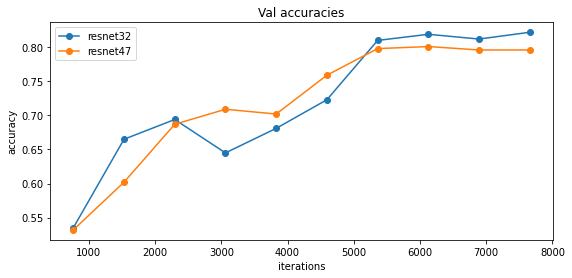

In [92]:
plt.title('Val accuracies')
for name in names:
    plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='upper left')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()